# Análisis Latinobarómetro 2024

Este notebook analiza los datos del Latinobarómetro 2024 para responder las siguientes preguntas de investigación.

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [272]:
df = pd.read_csv('Latinobarometro_2024.csv', sep=';', encoding='utf-8')
country_codes = pd.read_csv('country_codes.csv')
country_dict = dict(zip(country_codes['Country Code'], country_codes['Country Name']))
df['PAIS'] = df['IDENPA'].map(country_dict)


## 1. Satisfacción en la democracia

### 1.1. ¿Cómo se distribuye la "satisfacción con la democracia" a lo largo de América Latina?

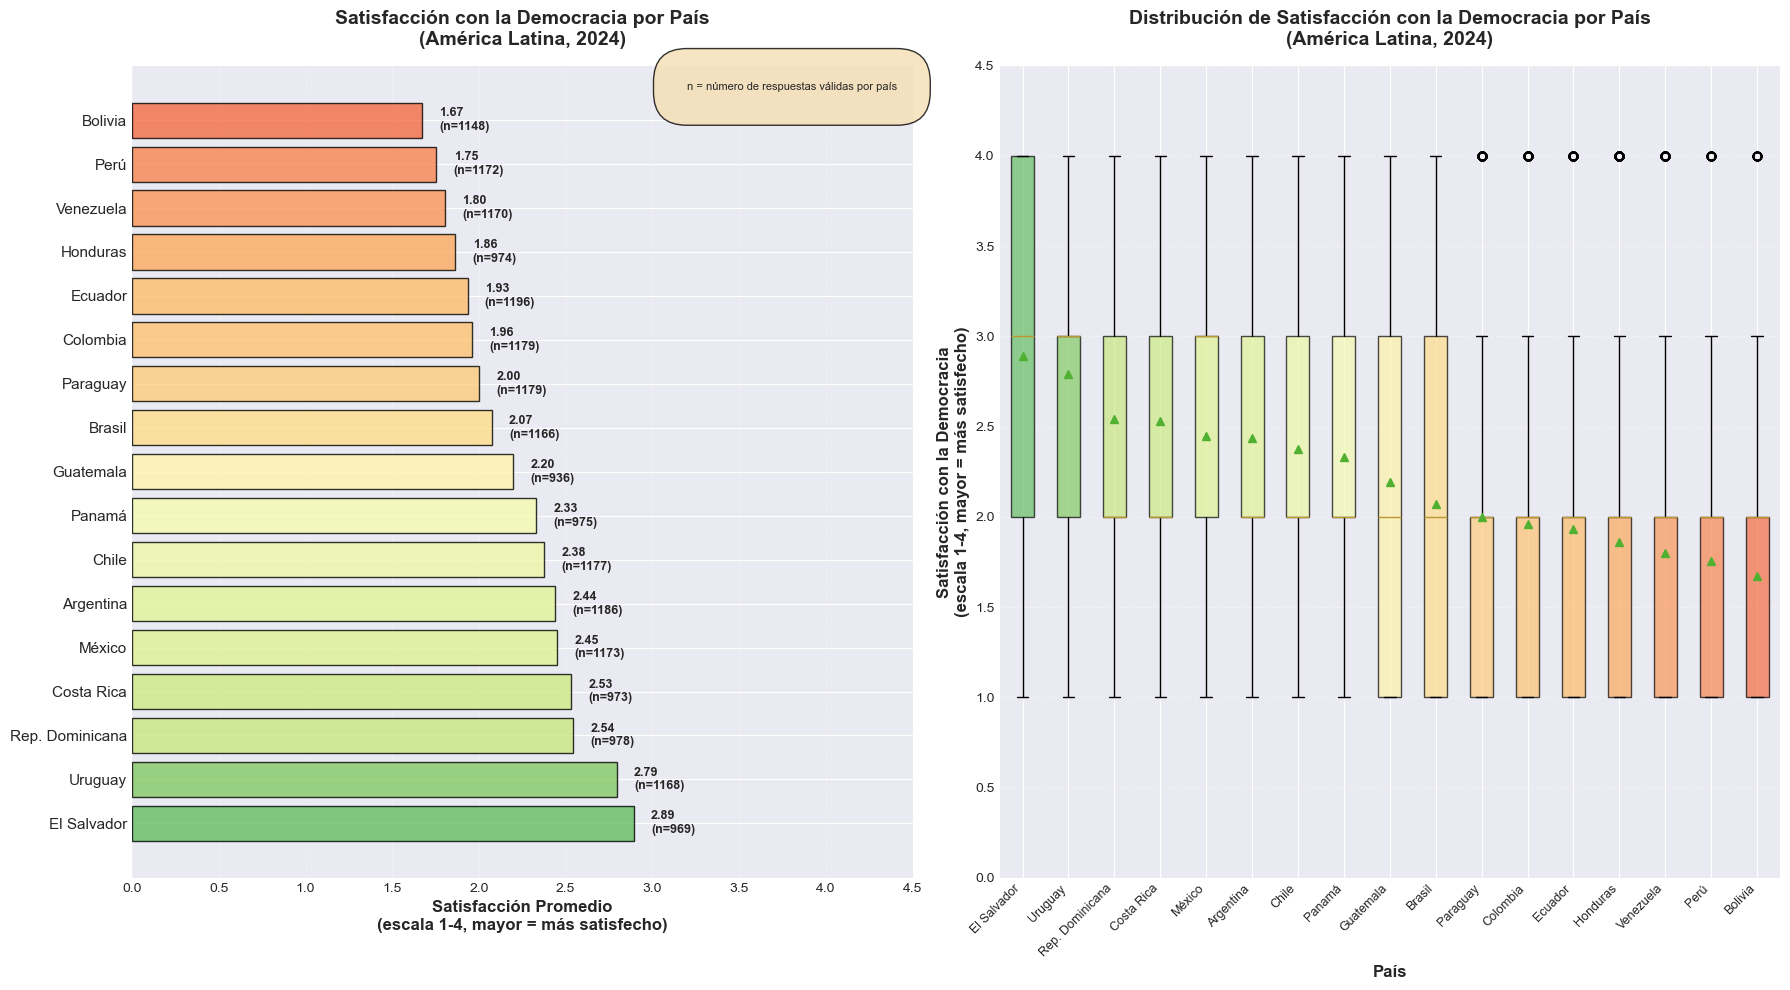

In [273]:
satisf_democ_var = 'P12STGBS.A'
df['satisf_democracia'] = df[satisf_democ_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
df.loc[df['satisf_democracia'].isin(codigos_especiales), 'satisf_democracia'] = np.nan
df.loc[~df['satisf_democracia'].isin([1, 2, 3, 4]), 'satisf_democracia'] = np.nan
df['satisf_democracia_inv'] = 5 - df['satisf_democracia']
satisf_por_pais = df.groupby('PAIS')['satisf_democracia_inv'].agg([('media', 'mean'), ('count', 'count')]).reset_index()
satisf_por_pais = satisf_por_pais.sort_values('media', ascending=False).reset_index(drop=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
min_satisf = satisf_por_pais['media'].min()
max_satisf = satisf_por_pais['media'].max()
range_satisf = max_satisf - min_satisf
colores = []
for media in satisf_por_pais['media']:
    normalized = (media - min_satisf) / range_satisf if range_satisf > 0 else 0.5
    color = plt.cm.RdYlGn(0.2 + normalized * 0.6)
    colores.append(color)
bars = ax1.barh(range(len(satisf_por_pais)), satisf_por_pais['media'], color=colores, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_yticks(range(len(satisf_por_pais)))
ax1.set_yticklabels(satisf_por_pais['PAIS'], fontsize=11)
ax1.set_xlabel('Satisfacción Promedio\n(escala 1-4, mayor = más satisfecho)', fontsize=12, fontweight='bold')
ax1.set_title('Satisfacción con la Democracia por País\n(América Latina, 2024)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_xlim(0, 4.5)
for i, (idx, row) in enumerate(satisf_por_pais.iterrows()):
    ax1.text(row['media'] + 0.1, i, f"{row['media']:.2f}\n(n={int(row['count'])})", va='center', fontsize=9, fontweight='bold')
legend_text = "n = número de respuestas válidas por país"
ax1.text(0.98, 0.98, legend_text, transform=ax1.transAxes, fontsize=8, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=3))
datos_boxplot = []
etiquetas_boxplot = []
colores_boxplot = []
for pais in satisf_por_pais['PAIS']:
    datos_pais = df[df['PAIS'] == pais]['satisf_democracia_inv'].dropna()
    if len(datos_pais) > 0:
        datos_boxplot.append(datos_pais.values)
        etiquetas_boxplot.append(pais)
        pais_idx = satisf_por_pais[satisf_por_pais['PAIS'] == pais].index[0]
        colores_boxplot.append(colores[pais_idx])
bp = ax2.boxplot(datos_boxplot, labels=etiquetas_boxplot, vert=True, patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], colores_boxplot):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Satisfacción con la Democracia\n(escala 1-4, mayor = más satisfecho)', fontsize=12, fontweight='bold')
ax2.set_xlabel('País', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Satisfacción con la Democracia por País\n(América Latina, 2024)', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 4.5)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()

### 1.2. ¿Qué países muestran los extremos de satisfacción e insatisfacción?

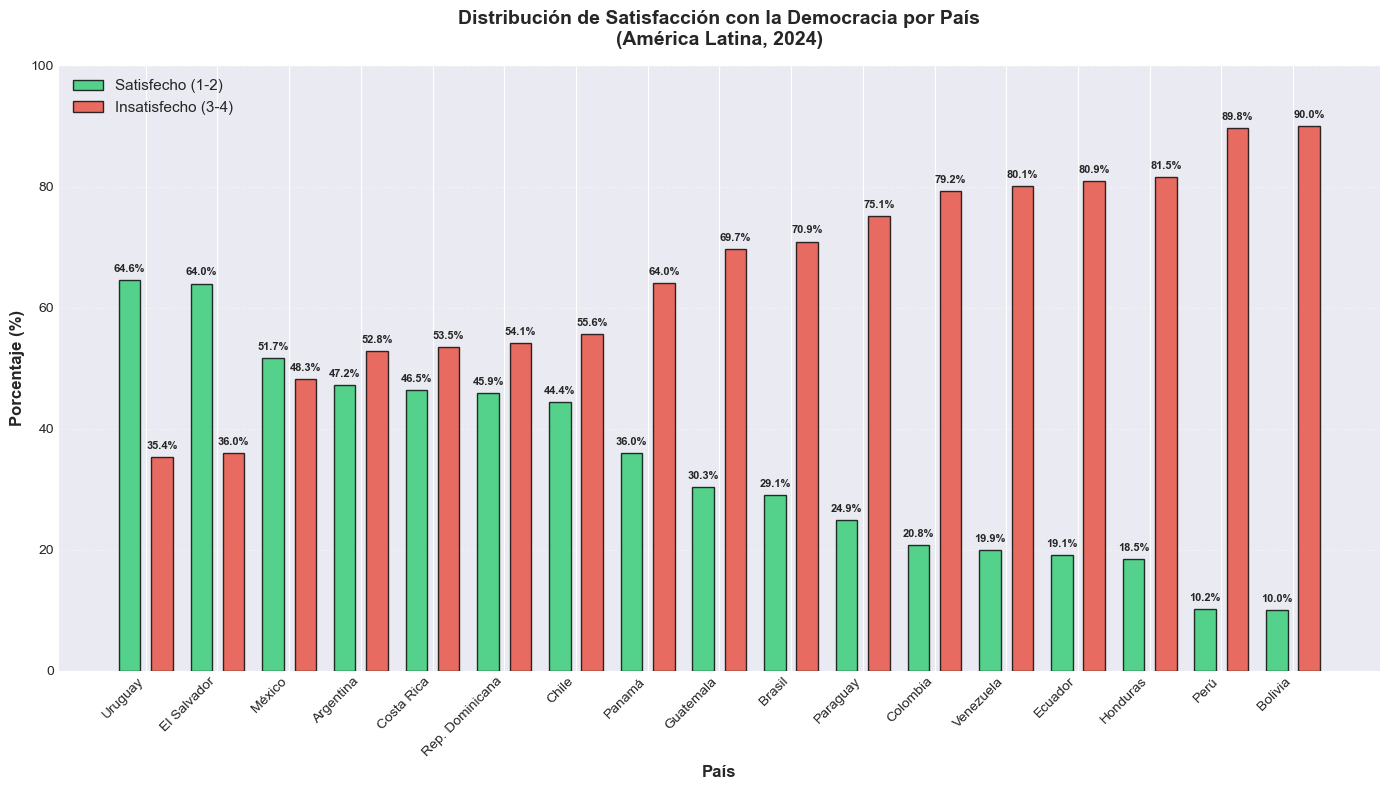

In [274]:
satisf_democ_var = 'P12STGBS.A'
df['satisf_democracia'] = df[satisf_democ_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
df.loc[df['satisf_democracia'].isin(codigos_especiales), 'satisf_democracia'] = np.nan
df.loc[~df['satisf_democracia'].isin([1, 2, 3, 4]), 'satisf_democracia'] = np.nan
df['satisf_democracia_inv'] = 5 - df['satisf_democracia']
def categorizar_satisfaccion(valor):
    if pd.isna(valor):
        return np.nan
    elif valor >= 3:
        return 'Satisfecho'
    elif valor <= 2:
        return 'Insatisfecho'
    else:
        return np.nan
df['categoria_satisf'] = df['satisf_democracia_inv'].apply(categorizar_satisfaccion)
tabla_cruzada = pd.crosstab(df['PAIS'], df['categoria_satisf'], normalize='index') * 100
tabla_cruzada = tabla_cruzada.sort_values('Satisfecho', ascending=False)
fig, ax = plt.subplots(figsize=(14, 8))
paises = tabla_cruzada.index.tolist()
x_pos = np.arange(len(paises))
width = 0.3
gap = 0.15
bars_satisf = ax.bar(x_pos - width/2 - gap/2, tabla_cruzada['Satisfecho'], width, label='Satisfecho (1-2)', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1)
bars_insatisf = ax.bar(x_pos + width/2 + gap/2, tabla_cruzada['Insatisfecho'], width, label='Insatisfecho (3-4)', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1)
ax.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('País', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Satisfacción con la Democracia por País\n(América Latina, 2024)', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(paises, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 100)
for i, (pais, row) in enumerate(tabla_cruzada.iterrows()):
    if row['Satisfecho'] > 2:
        ax.text(i - width/2 - gap/2, row['Satisfecho'] + 1, f"{row['Satisfecho']:.1f}%", ha='center', va='bottom', fontsize=8, fontweight='bold')
    if row['Insatisfecho'] > 2:
        ax.text(i + width/2 + gap/2, row['Insatisfecho'] + 1, f"{row['Insatisfecho']:.1f}%", ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.3. En Uruguay, ¿existe una brecha en la "satisfacción con la democracia" según el "nivel educativo" de los ciudadanos (años de estudio)?

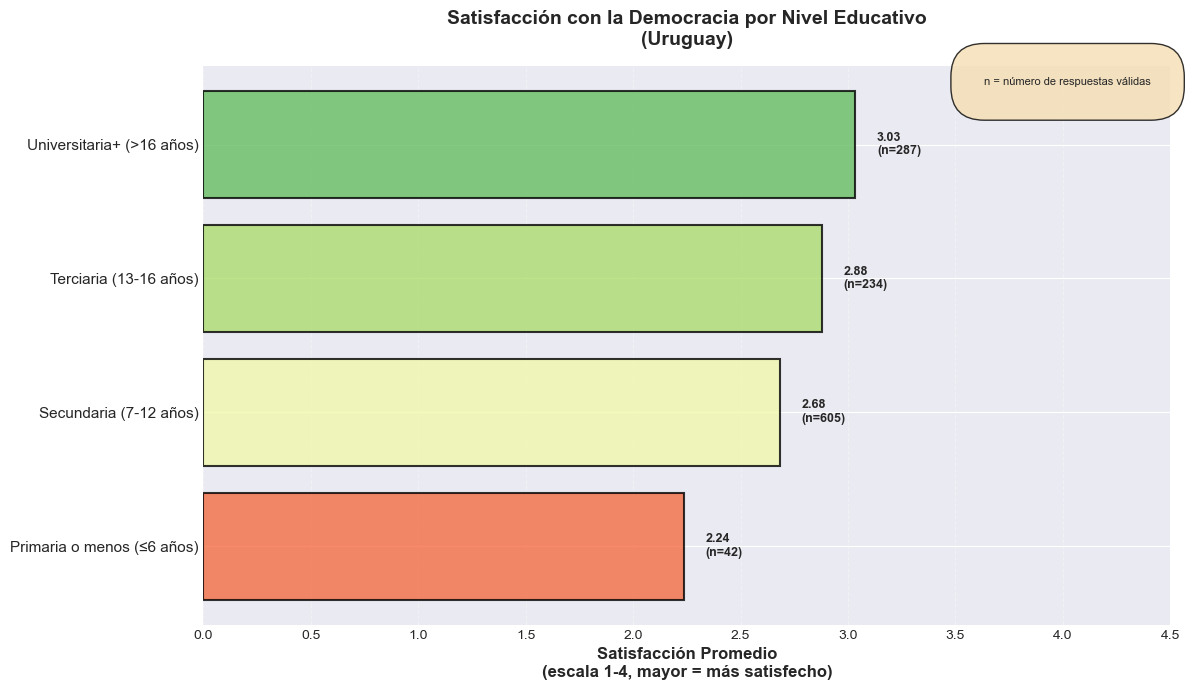

In [275]:
uruguay = df[df['PAIS'] == 'Uruguay'].copy()
satisf_democ_var = 'P12STGBS.A'
df['satisf_democracia'] = df[satisf_democ_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
df.loc[df['satisf_democracia'].isin(codigos_especiales), 'satisf_democracia'] = np.nan
df.loc[~df['satisf_democracia'].isin([1, 2, 3, 4]), 'satisf_democracia'] = np.nan
df['satisf_democracia_inv'] = 5 - df['satisf_democracia']
educ_var = 'REEDUC.1'
uruguay['nivel_educ'] = uruguay[educ_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
uruguay.loc[uruguay['nivel_educ'].isin(codigos_especiales), 'nivel_educ'] = np.nan
def categorizar_educacion(valor):
    if pd.isna(valor):
        return np.nan
    elif valor in [1, 2]:
        return 'Primaria o menos (≤6 años)'
    elif valor in [3, 4]:
        return 'Secundaria (7-12 años)'
    elif valor == 5:
        return 'Terciaria (13-16 años)'
    elif valor in [6, 7]:
        return 'Universitaria+ (>16 años)'
    else:
        return np.nan
uruguay['categoria_educ'] = uruguay['nivel_educ'].apply(categorizar_educacion)
uy_clean = uruguay[['satisf_democracia_inv', 'categoria_educ']].dropna()
satisf_por_educ = uy_clean.groupby('categoria_educ')['satisf_democracia_inv'].agg([('media', 'mean'), ('count', 'count')]).reset_index()
orden_cat = ['Primaria o menos (≤6 años)', 'Secundaria (7-12 años)', 'Terciaria (13-16 años)', 'Universitaria+ (>16 años)']
satisf_por_educ = satisf_por_educ.set_index('categoria_educ')
for cat in orden_cat:
    if cat not in satisf_por_educ.index:
        satisf_por_educ.loc[cat] = [np.nan, np.nan]
satisf_por_educ = satisf_por_educ.reindex(orden_cat).reset_index()
satisf_por_educ = satisf_por_educ.dropna(subset=['media'])
fig, ax = plt.subplots(figsize=(12, 7))
min_satisf = satisf_por_educ['media'].min()
max_satisf = satisf_por_educ['media'].max()
range_satisf = max_satisf - min_satisf
colores = []
for media in satisf_por_educ['media']:
    normalized = (media - min_satisf) / range_satisf if range_satisf > 0 else 0.5
    color = plt.cm.RdYlGn(0.2 + normalized * 0.6)
    colores.append(color)
bars = ax.barh(range(len(satisf_por_educ)), satisf_por_educ['media'], color=colores, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(satisf_por_educ)))
ax.set_yticklabels(satisf_por_educ['categoria_educ'], fontsize=11)
ax.set_xlabel('Satisfacción Promedio\n(escala 1-4, mayor = más satisfecho)', fontsize=12, fontweight='bold')
ax.set_title('Satisfacción con la Democracia por Nivel Educativo\n(Uruguay)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, 4.5)
for i, (idx, row) in enumerate(satisf_por_educ.iterrows()):
    ax.text(row['media'] + 0.1, i, f"{row['media']:.2f}\n(n={int(row['count'])})", va='center', fontsize=9, fontweight='bold')
legend_text = "n = número de respuestas válidas"
ax.text(0.98, 0.98, legend_text, transform=ax.transAxes, fontsize=8, ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=3))
plt.tight_layout()
plt.show()

## 2. Confianza en redes sociales

### 2.1. ¿Cómo varía la "confianza en las redes sociales" por grupo de edad en América Latina?

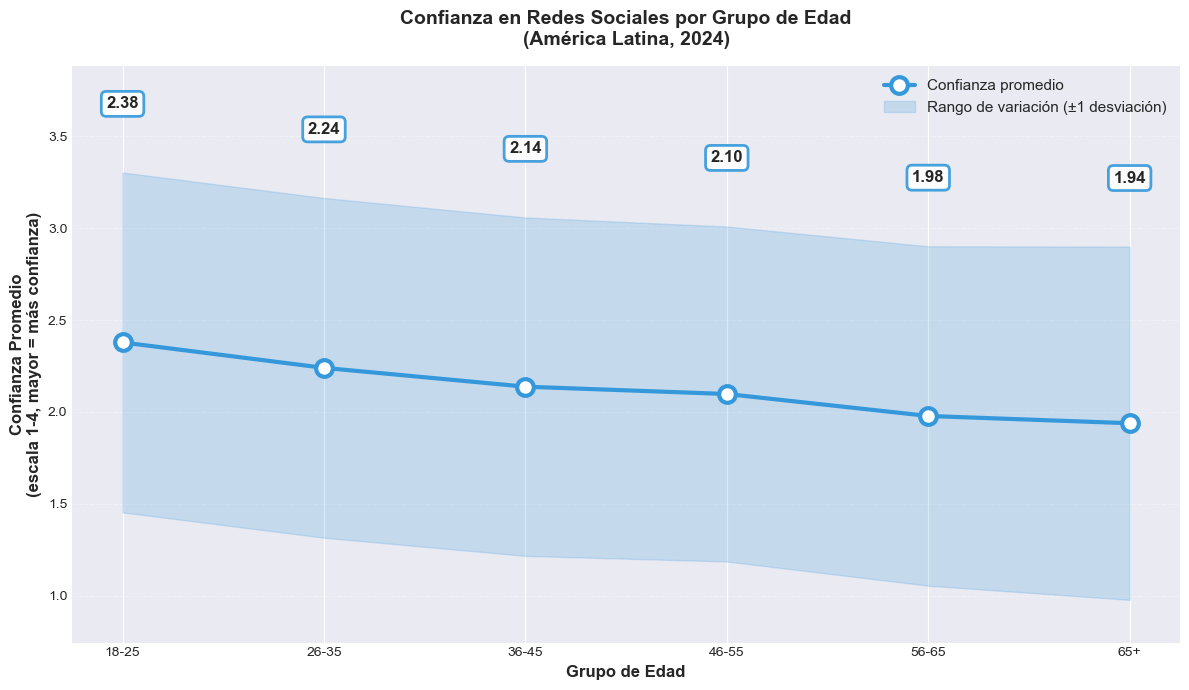

In [276]:
confianza_redes_var = 'P14ST.L'
df['confianza_redes'] = df[confianza_redes_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
df.loc[df['confianza_redes'].isin(codigos_especiales), 'confianza_redes'] = np.nan
df.loc[~df['confianza_redes'].isin([1, 2, 3, 4]), 'confianza_redes'] = np.nan
df['confianza_redes_inv'] = 5 - df['confianza_redes']
df['grupo_edad'] = pd.cut(df['EDAD'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
conf_por_edad = df.groupby('grupo_edad')['confianza_redes_inv'].agg([('mean', 'mean'), ('std', 'std')]).reset_index()
conf_por_edad = conf_por_edad.dropna()
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(conf_por_edad['grupo_edad'], conf_por_edad['mean'], marker='o', markersize=12, linewidth=3, color='#3498db', label='Confianza promedio', markerfacecolor='white', markeredgewidth=3, markeredgecolor='#3498db', zorder=3)
ax.fill_between(range(len(conf_por_edad)), conf_por_edad['mean'] - conf_por_edad['std'], conf_por_edad['mean'] + conf_por_edad['std'], alpha=0.2, color='#3498db', label='Rango de variación (±1 desviación)', zorder=1)
ax.set_ylabel('Confianza Promedio\n(escala 1-4, mayor = más confianza)', fontsize=12, fontweight='bold')
ax.set_xlabel('Grupo de Edad', fontsize=12, fontweight='bold')
ax.set_title('Confianza en Redes Sociales por Grupo de Edad\n(América Latina, 2024)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
ax.legend(fontsize=11, loc='best')
ax.set_xticks(range(len(conf_por_edad)))
ax.set_xticklabels(conf_por_edad['grupo_edad'])
y_max = (conf_por_edad['mean'] + conf_por_edad['std']).max()
y_min = (conf_por_edad['mean'] - conf_por_edad['std']).min()
y_range = y_max - y_min
espacio_superior = y_range * 0.15
for i, (idx, row) in enumerate(conf_por_edad.iterrows()):
    ax.text(i, row['mean'] + row['std'] + espacio_superior, f"{row['mean']:.2f}", ha='center', fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#3498db', linewidth=2), zorder=4)
ax.set_ylim(y_min - y_range*0.1, y_max + espacio_superior + y_range*0.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 2.2. ¿Uruguay sigue o difiere de la tendencia regional?

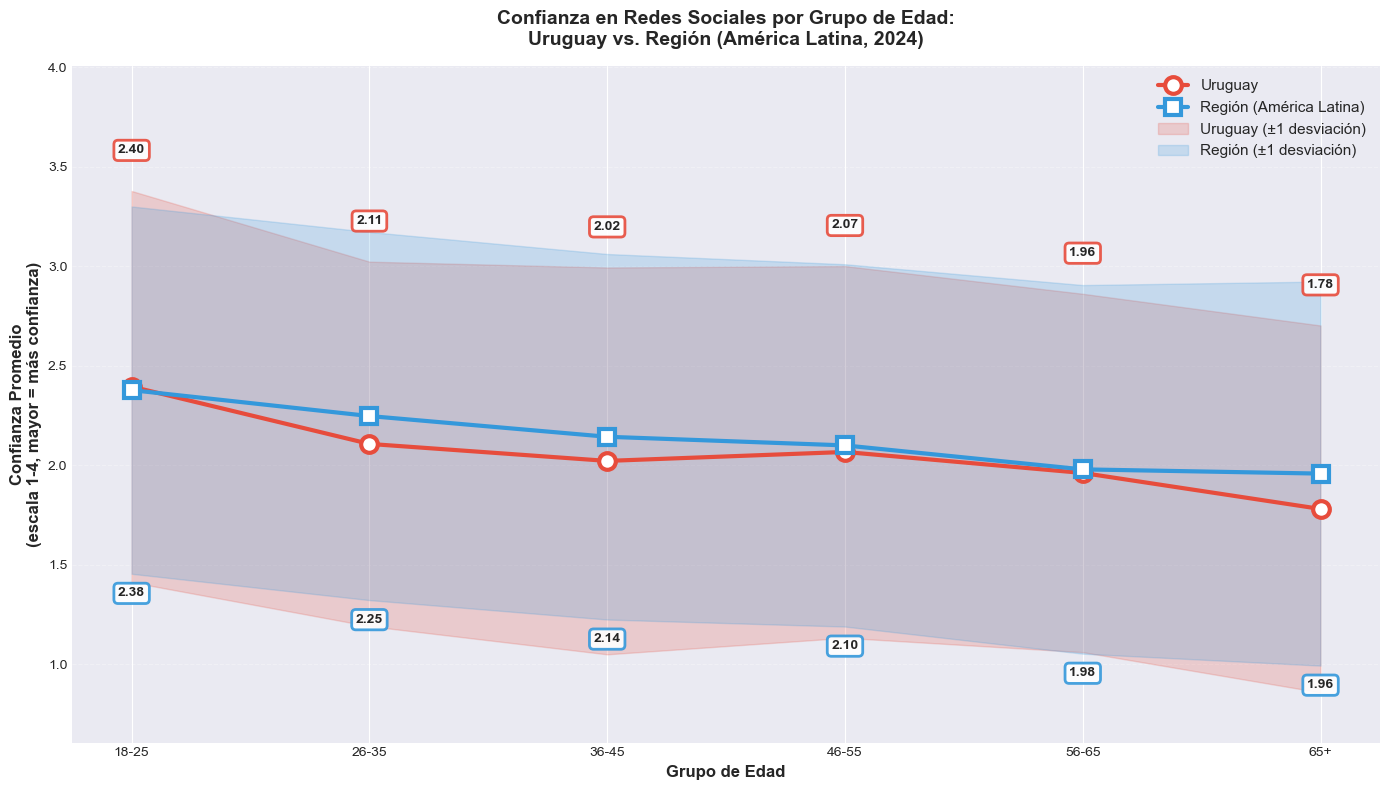

In [277]:
uruguay = df[df['PAIS'] == 'Uruguay'].copy()
conf_uy_por_edad = uruguay.groupby('grupo_edad')['confianza_redes_inv'].agg([('mean', 'mean'), ('std', 'std'), ('count', 'count')]).reset_index()
conf_uy_por_edad = conf_uy_por_edad.dropna()
region = df[df['PAIS'] != 'Uruguay'].copy()
conf_region_por_edad = region.groupby('grupo_edad')['confianza_redes_inv'].agg([('mean', 'mean'), ('std', 'std'), ('count', 'count')]).reset_index()
conf_region_por_edad = conf_region_por_edad.dropna()
grupos_comunes = sorted(set(conf_uy_por_edad['grupo_edad'].unique()) & set(conf_region_por_edad['grupo_edad'].unique()))
x_pos = range(len(grupos_comunes))
uy_means = []
uy_stds = []
region_means = []
region_stds = []
for grupo in grupos_comunes:
    uy_row = conf_uy_por_edad[conf_uy_por_edad['grupo_edad'] == grupo]
    region_row = conf_region_por_edad[conf_region_por_edad['grupo_edad'] == grupo]
    if len(uy_row) > 0:
        uy_means.append(uy_row['mean'].values[0])
        uy_stds.append(uy_row['std'].values[0])
    else:
        uy_means.append(np.nan)
        uy_stds.append(np.nan)
    if len(region_row) > 0:
        region_means.append(region_row['mean'].values[0])
        region_stds.append(region_row['std'].values[0])
    else:
        region_means.append(np.nan)
        region_stds.append(np.nan)
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(x_pos, uy_means, marker='o', markersize=12, linewidth=3, color='#e74c3c', label='Uruguay', markerfacecolor='white', markeredgewidth=3, markeredgecolor='#e74c3c', zorder=3)
ax.plot(x_pos, region_means, marker='s', markersize=12, linewidth=3, color='#3498db', label='Región (América Latina)', markerfacecolor='white', markeredgewidth=3, markeredgecolor='#3498db', zorder=3)
ax.fill_between(x_pos, [m - s if not np.isnan(m) and not np.isnan(s) else np.nan for m, s in zip(uy_means, uy_stds)], [m + s if not np.isnan(m) and not np.isnan(s) else np.nan for m, s in zip(uy_means, uy_stds)], alpha=0.2, color='#e74c3c', label='Uruguay (±1 desviación)', zorder=1)
ax.fill_between(x_pos, [m - s if not np.isnan(m) and not np.isnan(s) else np.nan for m, s in zip(region_means, region_stds)], [m + s if not np.isnan(m) and not np.isnan(s) else np.nan for m, s in zip(region_means, region_stds)], alpha=0.2, color='#3498db', label='Región (±1 desviación)', zorder=1)
ax.set_ylabel('Confianza Promedio\n(escala 1-4, mayor = más confianza)', fontsize=12, fontweight='bold')
ax.set_xlabel('Grupo de Edad', fontsize=12, fontweight='bold')
ax.set_title('Confianza en Redes Sociales por Grupo de Edad:\nUruguay vs. Región (América Latina, 2024)', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
ax.legend(fontsize=11, loc='best')
ax.set_xticks(x_pos)
ax.set_xticklabels(grupos_comunes)
y_max = max([m + s if not np.isnan(m) and not np.isnan(s) else 0 for m, s in zip(uy_means + region_means, uy_stds + region_stds)])
y_min = min([m - s if not np.isnan(m) and not np.isnan(s) else 4 for m, s in zip(uy_means + region_means, uy_stds + region_stds)])
y_range = y_max - y_min
espacio_superior = y_range * 0.15
for i, grupo in enumerate(grupos_comunes):
    if not np.isnan(uy_means[i]):
        ax.text(i, uy_means[i] + uy_stds[i] + espacio_superior*0.5, f"{uy_means[i]:.2f}", ha='center', fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#e74c3c', linewidth=2), zorder=4)
    if not np.isnan(region_means[i]):
        ax.text(i, region_means[i] - region_stds[i] - espacio_superior*0.3, f"{region_means[i]:.2f}", ha='center', fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#3498db', linewidth=2), zorder=4)
ax.set_ylim(y_min - y_range*0.1, y_max + espacio_superior + y_range*0.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Confianza y actitudes cívicas en Uruguay

### 3.1. ¿Existe correlación entre la "confianza en el gobierno", la "satisfacción con la democracia" y el "interés en la política" en Uruguay?

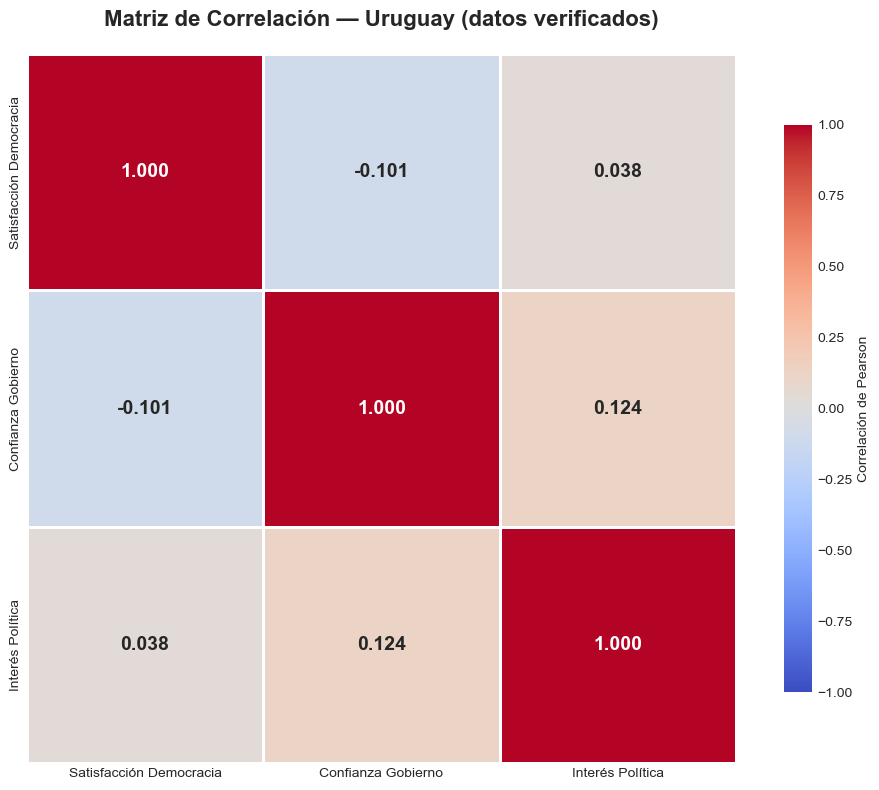

In [278]:
pais_col = 'PAIS'
df_uy = df[df[pais_col] == 'Uruguay'].copy()
variables = ['P12STGBS.A', 'P13ST', 'P15STGBS']
df_uy_clean = df_uy.copy()
codigos_invalidos = [-1, -2, -3, -8, -9, 77, 88, 99]
for var in variables:
    df_uy_clean.loc[df_uy_clean[var].isin(codigos_invalidos), var] = np.nan
for var in variables:
    df_uy_clean[var] = pd.to_numeric(df_uy_clean[var], errors='coerce')
df_corr = df_uy_clean[variables].dropna()
matriz_corr = df_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
matriz_corr_plot = matriz_corr.copy()
matriz_corr_plot.index = ['Satisfacción Democracia', 'Confianza Gobierno', 'Interés Política']
matriz_corr_plot.columns = ['Satisfacción Democracia', 'Confianza Gobierno', 'Interés Política']
sns.heatmap(matriz_corr_plot, annot=True, fmt='.3f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8, "label": "Correlación de Pearson"}, ax=ax, annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Matriz de Correlación — Uruguay (datos verificados)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4. Contraste acceso a internet vs. confianza en redes sociales

### 4.1. ¿Existe alguna diferencia en la "confianza en redes sociales" entre las personas que tienen y no tienen "acceso a internet" en Uruguay?

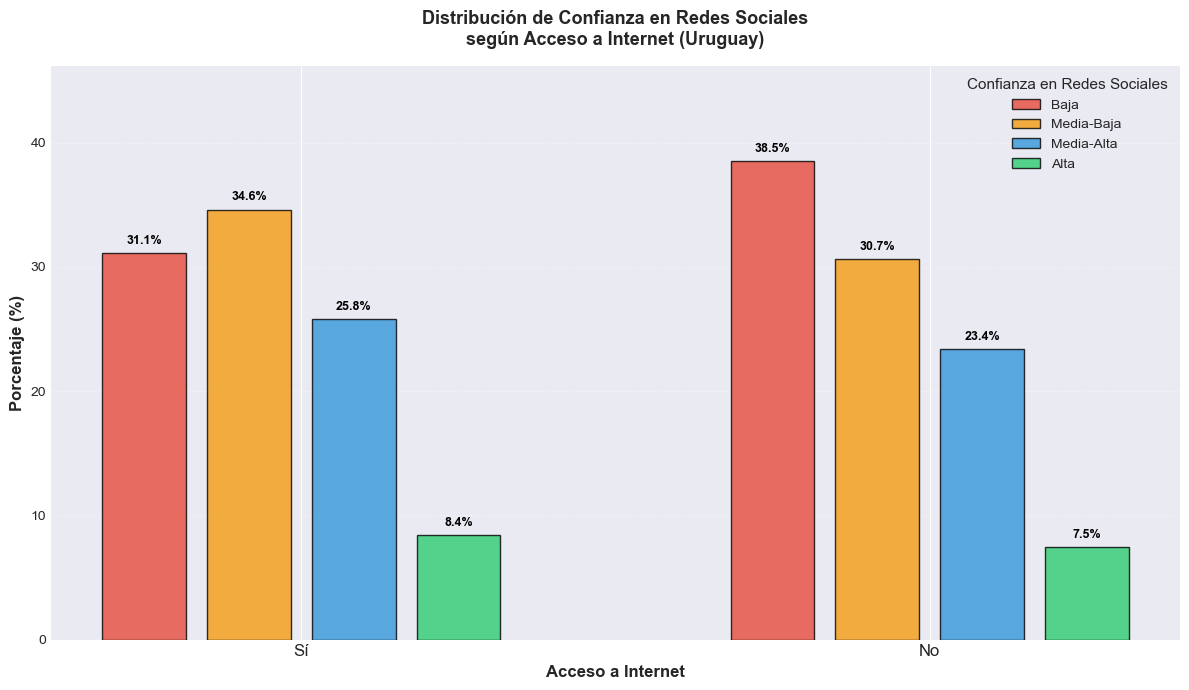

In [279]:
uruguay = df[df['PAIS'] == 'Uruguay'].copy()
confianza_redes_var = 'P14ST.L'
candidatas_internet = [col for col in uruguay.columns if any(kw in str(col).upper() for kw in ['INTERNET', 'NET', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22'])]
internet_var = None
for col in candidatas_internet:
    if 'INTERNET' in str(col).upper() or 'NET' in str(col).upper():
        internet_var = col
        break
if internet_var is None:
    internet_var = candidatas_internet[0]
uruguay['confianza_redes'] = uruguay[confianza_redes_var].copy()
codigos_especiales = [-1, -3, -5, 96, 97, 98, 99]
uruguay.loc[uruguay['confianza_redes'].isin(codigos_especiales), 'confianza_redes'] = np.nan
uruguay.loc[~uruguay['confianza_redes'].isin([1, 2, 3, 4]), 'confianza_redes'] = np.nan
uruguay['confianza_redes_inv'] = 5 - uruguay['confianza_redes']
uruguay['acceso_internet'] = uruguay[internet_var].copy()
codigos_especiales = [-1, -2, -3, -5, -8, -9, 96, 97, 98, 99]
uruguay.loc[uruguay['acceso_internet'].isin(codigos_especiales), 'acceso_internet'] = np.nan
uruguay['tiene_internet'] = uruguay['acceso_internet'].apply(lambda x: 'Sí' if pd.notna(x) and x == 1 else ('No' if pd.notna(x) else np.nan))
def categorizar_confianza(valor):
    if pd.isna(valor):
        return np.nan
    elif valor <= 1.5:
        return 'Baja'
    elif valor <= 2.5:
        return 'Media-Baja'
    elif valor <= 3.5:
        return 'Media-Alta'
    else:
        return 'Alta'
uruguay['categoria_confianza'] = uruguay['confianza_redes_inv'].apply(categorizar_confianza)
tabla_cruzada = pd.crosstab(uruguay['tiene_internet'], uruguay['categoria_confianza'], normalize='index') * 100
fig, ax1 = plt.subplots(1, 1, figsize=(12, 7))
categorias = ['Baja', 'Media-Baja', 'Media-Alta', 'Alta']
grupos = ['Sí', 'No']
n_grupos = len(grupos)
n_categorias = len(categorias)
porcentajes_si = [tabla_cruzada.loc['Sí', cat] if cat in tabla_cruzada.columns else 0 for cat in categorias]
porcentajes_no = [tabla_cruzada.loc['No', cat] if cat in tabla_cruzada.columns else 0 for cat in categorias]
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
x = np.array([0, 1.5])
width = 0.2
gap = 0.05
for i, (cat, color) in enumerate(zip(categorias, colors)):
    offset = (i - n_categorias/2 + 0.5) * (width + gap)
    ax1.bar(x + offset, [porcentajes_si[i], porcentajes_no[i]], width, label=cat, color=color, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Acceso a Internet', fontsize=12, fontweight='bold')
ax1.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Confianza en Redes Sociales\nsegún Acceso a Internet (Uruguay)', fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(grupos, fontsize=12)
ax1.legend(title='Confianza en Redes Sociales', fontsize=10, title_fontsize=11, loc='best')
ax1.set_ylim(0, max(max(porcentajes_si), max(porcentajes_no)) * 1.2)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for i, (cat, color) in enumerate(zip(categorias, colors)):
    offset = (i - n_categorias/2 + 0.5) * (width + gap)
    for j, (grupo, porcentaje) in enumerate(zip(grupos, [porcentajes_si[i], porcentajes_no[i]])):
        if porcentaje > 3:
            ax1.text(x[j] + offset, porcentaje + 0.5, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')
plt.tight_layout()
plt.show()